<a href="https://colab.research.google.com/github/hanjihun2000/machine-learning/blob/main/House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!wget –no-check-certificate 'https://docs.google.com/uc?export=download&id=1IVvuG3SMlarSSGmcliGFjq1fMxZtksE0' -O kaggle-kakr-housing-data.zip
!unzip -qq ./kaggle-kakr-housing-data.zip

--2023-09-16 10:47:31--  http://xn--no-check-certificate-2t2l/
Resolving xn--no-check-certificate-2t2l (xn--no-check-certificate-2t2l)... failed: Name or service not known.
wget: unable to resolve host address ‘xn--no-check-certificate-2t2l’
--2023-09-16 10:47:31--  https://docs.google.com/uc?export=download&id=1IVvuG3SMlarSSGmcliGFjq1fMxZtksE0
Resolving docs.google.com (docs.google.com)... 172.217.193.102, 172.217.193.139, 172.217.193.113, ...
Connecting to docs.google.com (docs.google.com)|172.217.193.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6kc1i9k3h7u4taocg37b1e895v5hi75a/1694861250000/17597719433809694239/*/1IVvuG3SMlarSSGmcliGFjq1fMxZtksE0?e=download&uuid=7e4aae8d-9640-4640-9296-e820261e838a [following]
--2023-09-16 10:47:32--  https://doc-00-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6kc1i9k3h7u4taocg37b1e895v

In [ ]:
train_data_path = './data/train.csv'
test_data_path = './data/test.csv'
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [ ]:
y = train['price']
# two different ways to delete a column
train.drop(['price', 'id', 'date'], axis=1, inplace=True)
del test['id']
del test['date']
train.tail()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15030,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
15034,2,0.75,1020,1076,2.0,0,0,3,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       15035 non-null  int64  
 1   bathrooms      15035 non-null  float64
 2   sqft_living    15035 non-null  int64  
 3   sqft_lot       15035 non-null  int64  
 4   floors         15035 non-null  float64
 5   waterfront     15035 non-null  int64  
 6   view           15035 non-null  int64  
 7   condition      15035 non-null  int64  
 8   grade          15035 non-null  int64  
 9   sqft_above     15035 non-null  int64  
 10  sqft_basement  15035 non-null  int64  
 11  yr_built       15035 non-null  int64  
 12  yr_renovated   15035 non-null  int64  
 13  zipcode        15035 non-null  int64  
 14  lat            15035 non-null  float64
 15  long           15035 non-null  float64
 16  sqft_living15  15035 non-null  int64  
 17  sqft_lot15     15035 non-null  int64  
dtypes: flo

In [ ]:
# check if there is any missing value
missing = train.isna().sum()
print(missing)

bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


<Axes: >

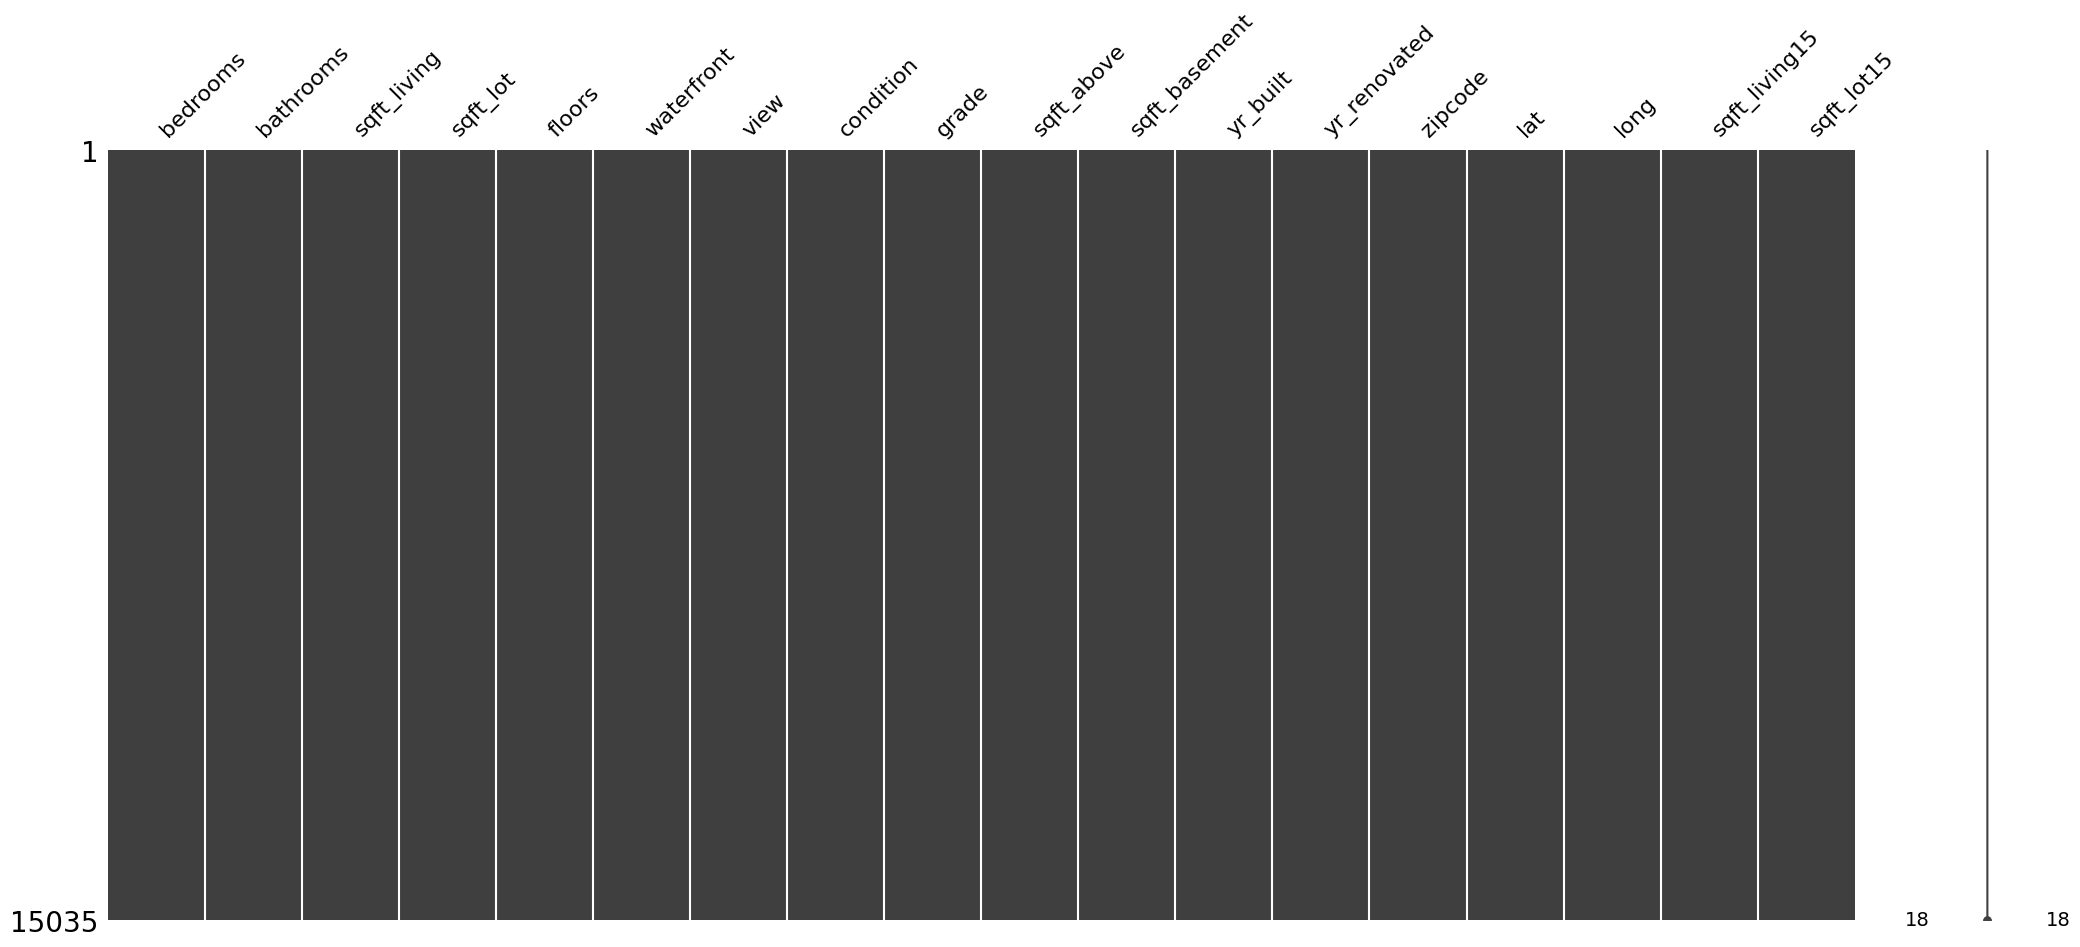

In [ ]:
import missingno as msno
%matplotlib inline
msno.matrix(train)

In [ ]:
train.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


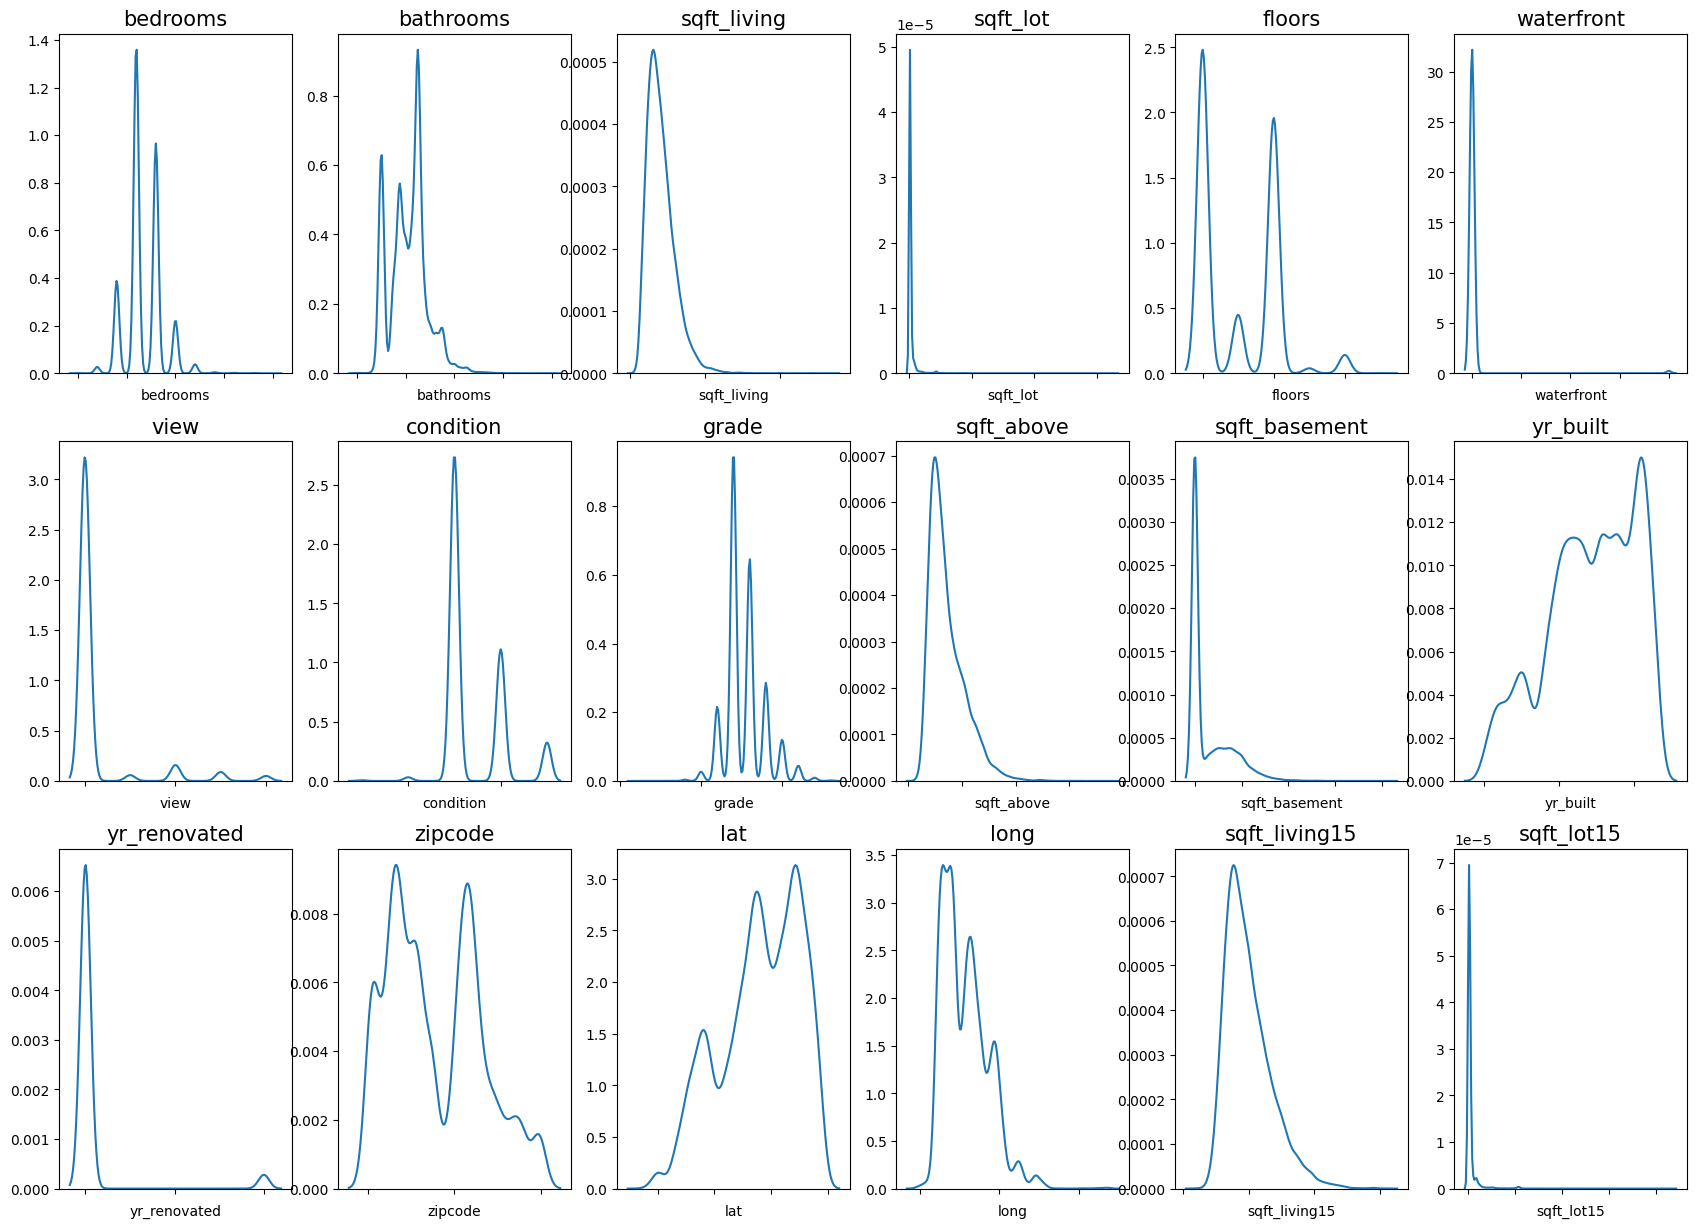

In [ ]:
fig, ax = plt.subplots(3, 6, figsize=(21, 15))
columns = train.columns
for row in range(3):
    for col in range(6):
      count = row*6+col
      sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
      ax[row][col].set_title(columns[count], fontsize=15)
      ax[row][col].set_ylabel("")
      ax[row][col].set(xticklabels=[])

In [ ]:
# log transformation for better data representation
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
for col in skew_columns:
    train[col] = np.log1p(train[col])

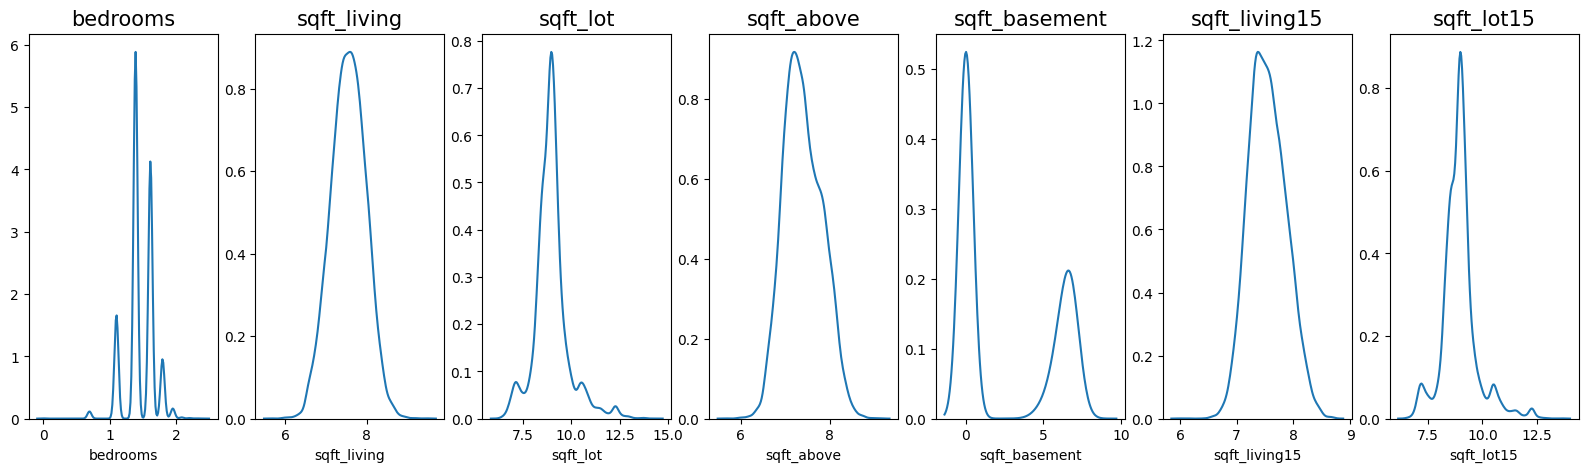

In [ ]:
fig, ax = plt.subplots(1, len(skew_columns), figsize=(20, 5))
for col in range(len(skew_columns)):
      sns.kdeplot(data=train[skew_columns[col]], ax=ax[col])
      ax[col].set_title(skew_columns[col], fontsize=15)
      ax[col].set_ylabel("")

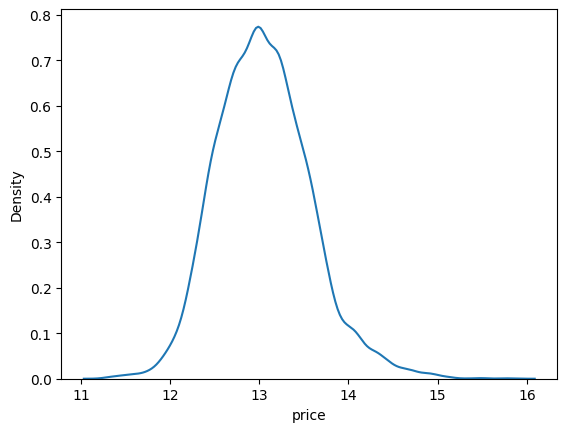

In [ ]:
# same log transformation on y (price)
# y needs to be returned back to the original using a function np.expm1()
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [ ]:
# create a function to calculate Root Mean Squared Error (rsme)
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, np.expm1(y_pred)))

In [ ]:
def get_scores(models, x, y):
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=random_state, test_size=0.2)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_val)
        df[model_name] = rmse(y_val, y_pred)
        score_df = pd.DataFrame(df, index=['rmse']).T.sort_values('rmse', ascending=False)
    return score_df

In [ ]:
# GridSearchCV for a single model with its param_grid
def get_gs(model, x, y, param_grid, cv, verbose=2, n_jobs=-1):
    gs = GridSearchCV(model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=cv, verbose=verbose, n_jobs=n_jobs)
    gs.fit(x, y)
    params = gs.cv_results_['params']
    score = gs.cv_results_['mean_test_score']
    results = pd.DataFrame(params)
    results['score'] = score
    results['rmse'] = np.sqrt(-1 * results['score'])
    results = results.sort_values(by=['rmse'])
    return results

In [ ]:
def save_submission(model, x, y, test, model_name, date=None):
    model.fit(x, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = './data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_{}.csv'.format(data_dir, model_name, date)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
random_state=1
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)
models = [gboost, xgboost, lightgbm, rdforest]

In [ ]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [1, 5, 10]
}
get_gs(gboost, train, y, param_grid, cv=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,max_depth,n_estimators,score,rmse
5,5,100,-0.170964,0.413478
8,10,100,-0.174061,0.417206
7,10,50,-0.174861,0.418164
4,5,50,-0.178264,0.422214
2,1,100,-0.234544,0.484297
6,10,10,-0.256831,0.506785
1,1,50,-0.270560,0.520154
3,5,10,-0.283984,0.532901
0,1,10,-0.403787,0.635442


In [ ]:
get_gs(lightgbm, train, y, param_grid, cv=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2324
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 18
[LightGBM] [Info] Start training from score 13.048122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,max_depth,n_estimators,score,rmse
8,10,100,-0.166602,0.408170
5,5,100,-0.171101,0.413644
7,10,50,-0.172510,0.415343
4,5,50,-0.179017,0.423105
2,1,100,-0.234510,0.484263
1,1,50,-0.270823,0.520407
6,10,10,-0.279640,0.528810
3,5,10,-0.284337,0.533233
0,1,10,-0.403745,0.635410


In [ ]:
get_scores(models, train, y)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2311
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 18
[LightGBM] [Info] Start training from score 13.043928


,rmse
LGBMRegressor,650291.067203
XGBRegressor,644892.706457
RandomForestRegressor,629828.581806
GradientBoostingRegressor,628969.630367


In [ ]:
model = LGBMRegressor(n_estimators=100, max_depth=10, random_state=random_state)
save_submission(model, train, y, test, 'lgbm', '16_05_2023')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2324
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 18
[LightGBM] [Info] Start training from score 13.048122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
./data/submission_lgbm_16_05_2023.csv saved!
